#Load Datasets

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sn
from sklearn import tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score, confusion_matrix

warnings.filterwarnings('ignore')
%matplotlib inline

targets = ['Low Spend', 'Medium Spend', 'High Spend']
attributes = ["NumBaskets_mean", "DistinticProducts_mean", "Qta_mean", "Qta_entropy", "Sale_mean", "Sale_entropy"]

In [6]:
# Training data
training_data = pd.read_csv("/content/drive/MyDrive/DM/Classification/normalized_data_classification_training_tot.csv")
training_data.drop(columns="Unnamed: 0", inplace=True)
training_data.head()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy,label
0,0.000000,0.121448,0.321975,0.129797,0.417977,0.894589,2
1,0.000000,0.005450,0.058248,0.002189,0.000000,0.000000,0
2,0.000000,0.354223,0.674745,0.574020,0.562301,0.934952,2
3,0.000000,0.081744,0.248724,0.054193,0.212806,0.623800,1
4,0.264706,0.083106,0.166454,0.169366,0.336874,0.844006,1


In [7]:
# Test data
test_data = pd.read_csv("/content/drive/MyDrive/DM/Classification/normalized_data_classification_test_tot.csv")
test_data.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], inplace=True)
test_data.head()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy,label
0,0.000000,0.016349,0.024235,0.052026,0.511860,0.630930,0
1,0.000000,0.381471,1.440051,0.310553,0.683548,0.792602,2
2,0.088235,0.162125,0.323820,0.230731,0.360275,0.793681,2
3,0.000000,0.069028,0.244473,0.058866,0.464311,0.770775,1
4,0.000000,0.092643,0.216837,0.083283,0.101818,0.550209,1


In [8]:
# Training set
Train_X = training_data[attributes].values
Train_Y = training_data["label"].values

# Test set
Test_X = test_data[attributes].values
Test_Y = test_data["label"].values

#Data Analysis

In [9]:
# Check types and null values
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3311 entries, 0 to 3310
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   NumBaskets_mean         3311 non-null   float64
 1   DistinticProducts_mean  3311 non-null   float64
 2   Qta_mean                3311 non-null   float64
 3   Sale_mean               3311 non-null   float64
 4   Qta_entropy             3311 non-null   float64
 5   Sale_entropy            3311 non-null   float64
 6   label                   3311 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 181.2 KB


In [10]:
# Statistical description of the data
training_data.describe()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy,label
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.057735,0.120153,0.207445,0.141933,0.501611,0.734843,1.017517
std,0.117653,0.107006,0.161356,0.120196,0.222969,0.241579,0.725659
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.048138,0.091837,0.057230,0.388729,0.628275,0.000000
50%,0.000000,0.092643,0.165816,0.110778,0.544568,0.812482,1.000000
75%,0.070588,0.160763,0.281144,0.196253,0.639243,0.908394,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


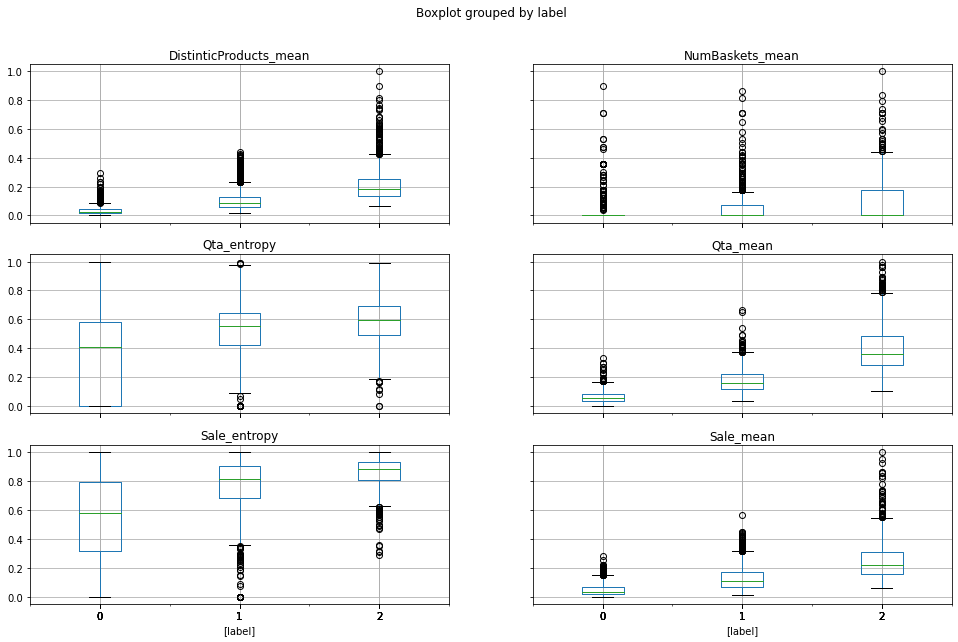

In [11]:
# Visualize attributes distribution by label
axs = training_data.boxplot(by="label", figsize=(16,10))

#Decision Tree

In [13]:
# Parameters for the Decision Tree grid search
dt_params = {
    "criterion": ["gini", "entropy"],
    "min_samples_split": [0.15, 0.1, 0.05, 0.01],
    "min_impurity_decrease": [0.0, 0.025, 0.05, 0.075, 0.1],
    "max_depth": [5, 10, 20]
}

In [14]:
# Use a Stratified k-fold cross validation approach with k=5
# Weighted F1 score is used as metric in the grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
dt_gs = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(class_weight="balanced"), 
    param_grid = dt_params,
    scoring = "f1_weighted",
    refit = True,
    cv = cv,
    return_train_score = True,
    verbose = 1
)
dt_gs = dt_gs.fit(Train_X, Train_Y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    7.2s finished


In [17]:
# Sort parameter configurations by validation score
dt_ranked_params = [x for x in sorted(zip(dt_gs.cv_results_["rank_test_score"],
                                          dt_gs.cv_results_["mean_test_score"],
                                          dt_gs.cv_results_["std_test_score"],
                                          dt_gs.cv_results_["mean_train_score"],
                                          dt_gs.cv_results_["std_train_score"],
                                          dt_gs.cv_results_["params"]),
                                      key = lambda k: k[0:-2])]

In [18]:
# Print the 5 best parameter configurations
for c in dt_ranked_params[0:6]:
  print("Rank " + str(c[0]))
  print("   Combination: " + str(c[5]))
  print("   Validation score mean:   " + str(c[1]))
  print("   Validation score stddev: " + str(c[2]))
  print("   Training score mean:     " + str(c[3]))
  print("   Training score stddev:   " + str(c[4]))

Rank 1
   Combination: {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_split': 0.01}
   Validation score mean:   0.8530408649149361
   Validation score stddev: 0.004184467890205595
   Training score mean:     0.9140198984773271
   Training score stddev:     0.005315026832241741
Rank 2
   Combination: {'criterion': 'entropy', 'max_depth': 20, 'min_impurity_decrease': 0.0, 'min_samples_split': 0.01}
   Validation score mean:   0.8522937226427582
   Validation score stddev: 0.004397745540652739
   Training score mean:     0.9145586011686564
   Training score stddev:     0.0055133003186196945
Rank 3
   Combination: {'criterion': 'entropy', 'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_split': 0.05}
   Validation score mean:   0.8480610409277023
   Validation score stddev: 0.013349599843274164
   Training score mean:     0.8629282077303945
   Training score stddev:     0.005813815122709385
Rank 4
   Combination: {'criterion': 'entropy', 'max

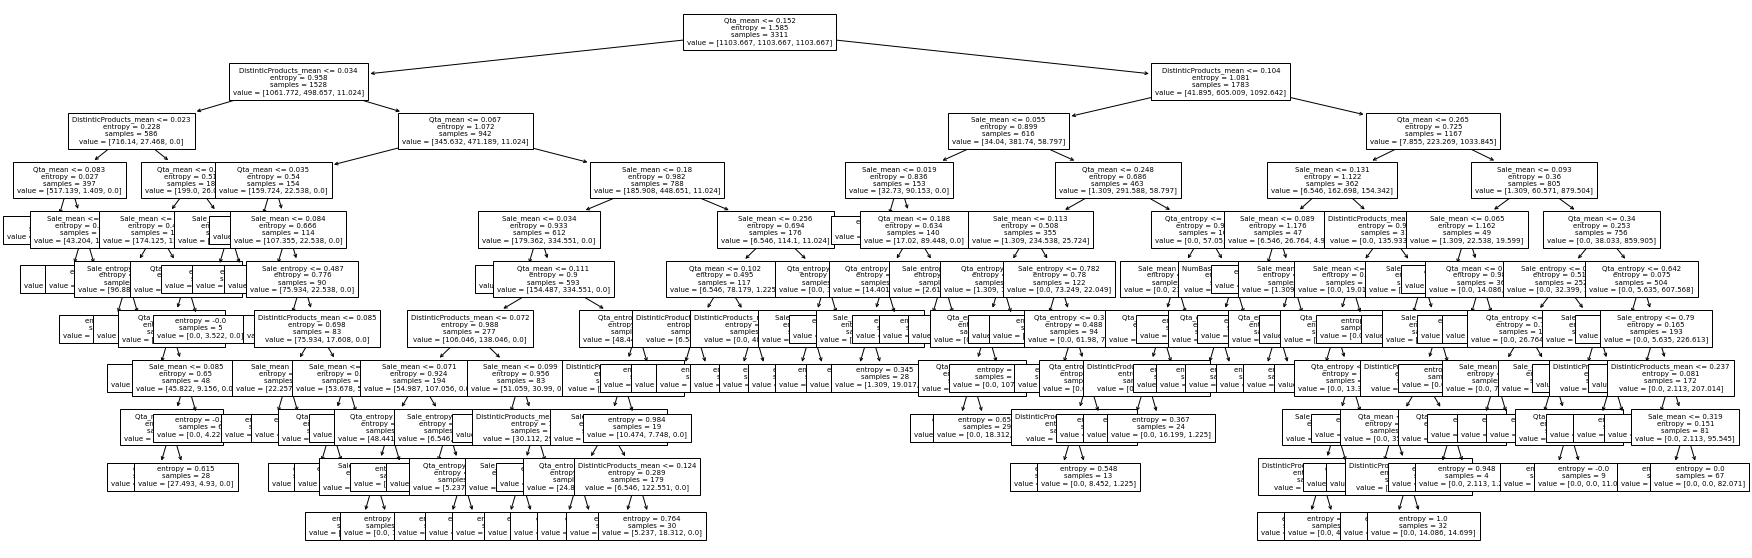

In [ ]:
# Get best model and display it
dt_best_model = dt_gs.best_estimator_
fig, ax = plt.subplots(1, 1, figsize=(30,10))
tr = tree.plot_tree(
    dt_best_model,
    feature_names=attributes,
    ax=ax,
    fontsize=7)

In [ ]:
# Print importance of the attributes
print("Attributes importance:")
for (name, importance) in sorted(zip(attributes, dt_best_model.feature_importances_), key = lambda k: k[1], reverse=True):
  print("\t" + name + ": " + str(importance))

Attributes importance:
	Qta_mean: 0.5485205400573238
	DistinticProducts_mean: 0.2639942307513434
	Sale_mean: 0.1351791015487831
	Qta_entropy: 0.03193864401814916
	Sale_entropy: 0.019278120652489836
	NumBaskets_mean: 0.0010893629719108328


In [ ]:
def plot_confusion_matrix(y_true,y_pred,filename):
  matrix = confusion_matrix(y_true,y_pred,labels = [0,1,2])
  names = ['Low Spend','Medium Spend', 'High Spend']
  row,column = matrix.shape
  values = []
  for i in range(row):
    single_row_values = []
    for j in range(column):
      single_row_values.append(matrix[j,i]/len(y_true))
    values.append(single_row_values)
  df_cm = pd.DataFrame(matrix, index = names, columns = names)
  plt.figure(figsize = (10,7))
  ax = sn.heatmap(df_cm, annot=values,fmt='.4f',cmap='viridis',cbar = False,square = True)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  ax.xaxis.set_label_position('top') 
  plt.savefig(filename + '.png')

Training test results:
              precision    recall  f1-score   support

   Low Spend       0.88      0.95      0.91       843
Medium Spend       0.95      0.85      0.89      1567
  High Spend       0.87      0.97      0.92       901

    accuracy                           0.91      3311
   macro avg       0.90      0.92      0.91      3311
weighted avg       0.91      0.91      0.90      3311

Weighted One-vs-One ROC AUC score:	0.988429
Weighted One-vs-Rest ROC AUC score:	0.986574


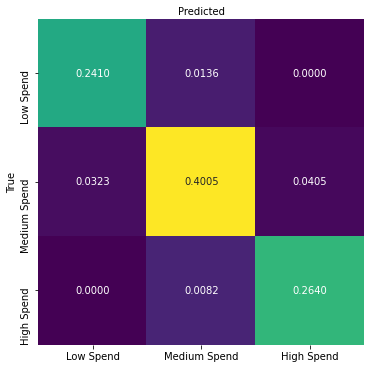

In [ ]:
# Print prediction results on training set
y_pred_train = dt_best_model.predict(Train_X)
y_prob_train = dt_best_model.predict_proba(Train_X)

print("Training test results:")
print(classification_report(Train_Y, y_pred_train, target_names=targets))
print("Weighted One-vs-One ROC AUC score:\t{:.6f}".format(roc_auc_score(Train_Y, y_prob_train, multi_class="ovo", average="weighted")))
print("Weighted One-vs-Rest ROC AUC score:\t{:.6f}".format(roc_auc_score(Train_Y, y_prob_train, multi_class="ovr", average="weighted")))
plot_confusion_matrix(y_pred_train,Train_Y,'./confusion_matrix_train') 
#'/content/drive/MyDrive/DM/Classification/Decision_Tree_Random_Forest/Decision_Tree/confusion_matrix_train'
plt.gcf().set_size_inches((6, 6))

Test test results:
              precision    recall  f1-score   support

   Low Spend       0.85      0.89      0.87       211
Medium Spend       0.88      0.79      0.83       392
  High Spend       0.81      0.91      0.86       232

    accuracy                           0.85       835
   macro avg       0.84      0.86      0.85       835
weighted avg       0.85      0.85      0.85       835

Weighted One-vs-One ROC AUC score:	0.943639
Weighted One-vs-Rest ROC AUC score:	0.936760


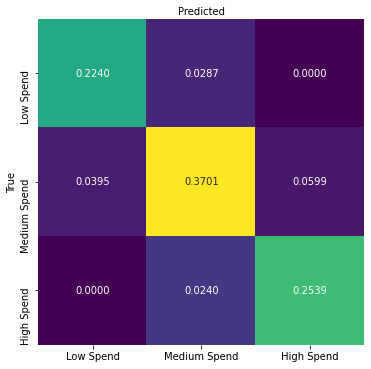

In [ ]:
# Print prediction results on test set
y_pred_test = dt_best_model.predict(Test_X)
y_prob_test = dt_best_model.predict_proba(Test_X)

print("Test test results:")
print(classification_report(Test_Y, y_pred_test, target_names=targets))
print("Weighted One-vs-One ROC AUC score:\t{:.6f}".format(roc_auc_score(Test_Y, y_prob_test, multi_class="ovo", average="weighted")))
print("Weighted One-vs-Rest ROC AUC score:\t{:.6f}".format(roc_auc_score(Test_Y, y_prob_test, multi_class="ovr", average="weighted")))
plot_confusion_matrix(y_pred_test,Test_Y,'/content/drive/MyDrive/DM/Classification/Decision_Tree_Random_Forest/Decision_Tree/confusion_matrix_test') 
#'/content/drive/MyDrive/DM/Classification/Decision_Tree_Random_Forest/Decision_Tree/confusion_matrix_test'
plt.gcf().set_size_inches((6, 6))

#Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# Parameters for the Random Forest grid search
rf_params = {
    "n_estimators": [10, 50, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [10, 20, 30]
}

In [22]:
# Use a Stratified k-fold cross validation approach with k=5
# Weighted F1 score is used as metric in the grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
rf_gs = GridSearchCV(
    estimator = RandomForestClassifier(class_weight="balanced"), 
    param_grid = rf_params,
    scoring = "f1_weighted",
    refit = True,
    cv = cv,
    return_train_score = True,
    verbose = 1
)
rf_gs = rf_gs.fit(Train_X, Train_Y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   30.0s finished


In [23]:
# Sort parameter configurations by validation score
rf_ranked_params = [x for x in sorted(zip(rf_gs.cv_results_["rank_test_score"],
                                          rf_gs.cv_results_["mean_test_score"],
                                          rf_gs.cv_results_["std_test_score"],
                                          rf_gs.cv_results_["mean_train_score"],
                                          rf_gs.cv_results_["std_train_score"],
                                          rf_gs.cv_results_["params"]),
                                      key = lambda k: k[0:-2])]

In [24]:
# Print the 5 best parameter configurations
for c in rf_ranked_params[0:6]:
  print("Rank " + str(c[0]))
  print("   Combination: " + str(c[5]))
  print("   Validation score mean:   " + str(c[1]))
  print("   Validation score stddev: " + str(c[2]))
  print("   Training score mean:     " + str(c[3]))
  print("   Training score stddev:   " + str(c[4]))

Rank 1
   Combination: {'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 100}
   Validation score mean:   0.8925076373584651
   Validation score stddev: 0.009938339977411934
   Training score mean:     1.0
   Training score stddev:   0.0
Rank 2
   Combination: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}
   Validation score mean:   0.889200344096291
   Validation score stddev: 0.010149655170878541
   Training score mean:     1.0
   Training score stddev:   0.0
Rank 3
   Combination: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
   Validation score mean:   0.8891708378005443
   Validation score stddev: 0.006988859905004449
   Training score mean:     0.983836739850568
   Training score stddev:   0.0016978442677812045
Rank 4
   Combination: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 50}
   Validation score mean:   0.8882534610123521
   Validation score stddev: 0.009004642075380303
   Training score mean:     0.9996224473599735
   Traini

In [ ]:
# Get the best model
rf_best_model = rf_gs.best_estimator_

Training test results:
              precision    recall  f1-score   support

   Low Spend       1.00      1.00      1.00       843
Medium Spend       1.00      1.00      1.00      1567
  High Spend       1.00      1.00      1.00       901

    accuracy                           1.00      3311
   macro avg       1.00      1.00      1.00      3311
weighted avg       1.00      1.00      1.00      3311

Weighted One-vs-One ROC AUC score:	1.000000
Weighted One-vs-Rest ROC AUC score:	1.000000


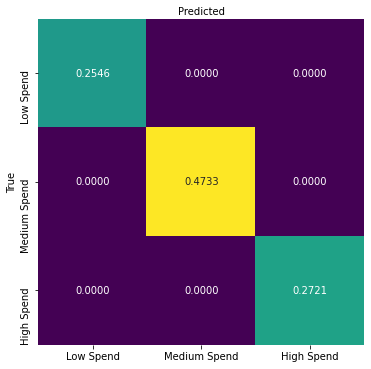

In [ ]:
# Print prediction results on training set
y_pred_train = rf_best_model.predict(Train_X)
y_prob_train = rf_best_model.predict_proba(Train_X)

print("Training test results:")
print(classification_report(Train_Y, y_pred_train, target_names=targets))
print("Weighted One-vs-One ROC AUC score:\t{:.6f}".format(roc_auc_score(Train_Y, y_prob_train, multi_class="ovo", average="weighted")))
print("Weighted One-vs-Rest ROC AUC score:\t{:.6f}".format(roc_auc_score(Train_Y, y_prob_train, multi_class="ovr", average="weighted")))
plot_confusion_matrix(y_pred_train,Train_Y,'./confusion_matrix_train') 
#'/content/drive/MyDrive/DM/Classification/Decision_Tree_Random_Forest/Random_Forest/confusion_matrix_train
plt.gcf().set_size_inches((6, 6))

Test test results:
              precision    recall  f1-score   support

   Low Spend       0.91      0.86      0.88       211
Medium Spend       0.85      0.89      0.87       392
  High Spend       0.89      0.87      0.88       232

    accuracy                           0.87       835
   macro avg       0.88      0.87      0.88       835
weighted avg       0.88      0.87      0.87       835

Weighted One-vs-One ROC AUC score:	0.966118
Weighted One-vs-Rest ROC AUC score:	0.961077


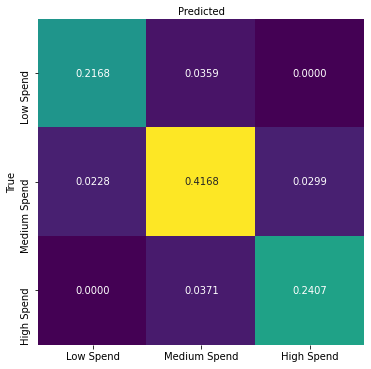

In [ ]:
# Print prediction results on test set
y_pred_test = rf_best_model.predict(Test_X)
y_prob_test = rf_best_model.predict_proba(Test_X)

print("Test test results:")
print(classification_report(Test_Y, y_pred_test, target_names=targets))
print("Weighted One-vs-One ROC AUC score:\t{:.6f}".format(roc_auc_score(Test_Y, y_prob_test, multi_class="ovo", average="weighted")))
print("Weighted One-vs-Rest ROC AUC score:\t{:.6f}".format(roc_auc_score(Test_Y, y_prob_test, multi_class="ovr", average="weighted")))
plot_confusion_matrix(y_pred_test,Test_Y,'/content/drive/MyDrive/DM/Classification/Decision_Tree_Random_Forest/Random_Forest/confusion_matrix_test') 
plt.gcf().set_size_inches((6, 6))

In [ ]:
# Print importance of the attributes
print("Attributes importance:")
for (name, importance) in sorted(zip(attributes, rf_best_model.feature_importances_), key = lambda k: k[1], reverse=True):
  print("\t" + name + ": " + str(importance))

Attributes importance:
	Qta_mean: 0.39397996321754486
	DistinticProducts_mean: 0.24644337342922826
	Sale_mean: 0.194142385716908
	Sale_entropy: 0.08052208770766918
	Qta_entropy: 0.06745994590301645
	NumBaskets_mean: 0.017452244025633456
